In [1]:
import os

os.environ.update({"OMP_NUM_THREADS":"1",
                   "MKL_NUM_THREADS":"1",
                   "OPENBLAS_NUM_THREADS":"1"})

In [2]:
import torch
import multiprocessing as mp

torch.set_num_threads(1)
torch.set_num_interop_threads(1)

if mp.get_start_method(allow_none=True) != "fork":
    mp.set_start_method("fork")

In [3]:
%load_ext autoreload
%autoreload 2

import torch, random, math, re
from typing import Tuple, List, Dict, Callable, Union
import numpy as np
from torch import Tensor
from polysym import PolySymModel


def gen_lin(x: Tensor):
    a_mean = np.random.uniform(-10, 10)
    a_sigma = np.random.uniform(.1, 3)

    b_mean = np.random.uniform(-100, 100)
    b_sigma = np.random.uniform(.1, 30)

    alphas = torch.tensor(np.random.normal(loc=a_mean, scale=a_sigma, size=x.shape[0])).unsqueeze(1)
    betas = torch.tensor(np.random.normal(loc=b_mean, scale=b_sigma, size=x.shape[0])).unsqueeze(1)

    return (x * alphas) + betas

def gen_cos(x: Tensor):
    A  = np.random.uniform(-10, 10)
    om  = np.random.uniform(-3, 3)
    phi = np.random.uniform(0, 4*math.pi)      # start phase

    return A * torch.cos(om * x + phi) + random.uniform(-5, 5)

def gen_noise(x: Tensor):

    amp = np.random.uniform(-10, 10)
    base = np.random.uniform(-10, 10)

    return torch.randn_like(x) * amp + base

def gen_brownian(x: Tensor):

    amp = np.random.uniform(-10, 10)
    starts = torch.tensor(np.random.uniform(-10, 10, x.shape[0])).unsqueeze(1)

    return (torch.cumsum(torch.randn_like(x), dim=-1) + starts) * amp

def gen_gaussian(x: Tensor):
    n_obs, t = x.shape
    out = torch.zeros_like(x)

    for obs in range(n_obs):
        n_peaks = np.random.randint(1, 5)
        t_vals = x[obs, :]
        t_min, t_max = t_vals.min().item(), t_vals.max().item()

        peaks_pos = torch.rand(n_peaks).sort(descending=False).values * (t_max - t_min) + t_min
        heights = np.random.uniform(1, 5, n_peaks) * np.random.choice([-1, 1], n_peaks)
        sds = np.random.uniform(0.1, 1.0, n_peaks)

        vec = torch.zeros_like(t_vals)
        for mu, amp, sd in zip(peaks_pos, heights, sds):
            vec += amp * torch.exp(-((t_vals - mu) ** 2) / (2 * sd ** 2))

        out[obs, :] = vec

    a = np.random.uniform(-10, 10)
    b = np.random.uniform(-10, 10)

    return out * a + b

def gen_dirac(x: Tensor):

    n_obs = x.shape[0]
    t = x.shape[1]
    new_x = torch.zeros_like(x)

    for obs in range(n_obs):

        n_peaks = np.random.randint(2, 6)
        peaks_starts = sorted(np.random.randint(0, t, n_peaks))
        peaks_slopes = np.random.uniform(1, 2, n_peaks)
        signs = np.random.choice([-1, 1], n_peaks)
        peaks_slopes *= signs
        peaks_resets = np.random.uniform(2, 5, n_peaks) * np.sign(peaks_slopes)

        a = np.random.uniform(.5, 5)
        a *= np.random.choice([-1, 1])
        b = np.random.uniform(-10, 10)

        # Process each peak
        for start_idx, slope, sign, reset_val in zip(peaks_starts, peaks_slopes, signs, peaks_resets):

            # Ramp up/down from 'start_idx' onward
            for i in range(start_idx + 1, t):
                new_x[obs, i] = new_x[obs, i - 1] + slope

                # If we hit/exceed threshold, reset and stop processing this peak
                exceed = new_x[obs, i] >= reset_val if sign == 1 else new_x[obs, i] <= reset_val

                if exceed:
                    new_x[obs, i] = 0
                    break

        new_x[obs, :] = new_x[obs, :] * a + b

    return new_x

def make_dataset(
        v_types: list[str],
        n_sca: int,
        expr: str,
        target_dim: int,  # 1 for scalar output 2 for vectorial output
        n_obs: int = 100,
        max_v_length: int = 100,
        clip_series: bool = False,
        seed: Union[int, None] = None
):

        if seed is not None:
            torch.manual_seed(seed)
            random.seed(seed)
            np.random.seed(seed)

        n_vec = len(v_types)
        X3d = torch.full((n_obs, n_vec, max_v_length), torch.nan)
        X2d = torch.full((n_obs, n_sca), torch.nan)

        # check if variables are matching:
        vec_matches = list(set(re.findall(r'\bv\d\b', expr)))
        assert len(vec_matches) == n_vec, 'Unequal amount of time-series variables found in expression and in v_types'
        vec_n = sorted([int(v[-1]) for v in vec_matches])
        assert vec_n == list(range(n_vec)), 'Found differences betwen vec_types and time-series used in expression.'

        sca_matches = re.findall(r'\bx\d\b', expr)
        assert len(sca_matches) == n_sca, 'Unequal amount of scalar variables found in expression and n_sca'

        # Generate random linspaces:
        for obs in range(n_obs):
            t0, t1 = torch.rand(2).sort().values * 25

            lsp = torch.linspace(t0, t1, max_v_length)
            for v in range(n_vec):
                X3d[obs, v, :] = lsp

        # Generate data:
        # Vectors
        for vi, v_type in enumerate(v_types):
            func = TYPE_MAP[v_type]
            X3d[:, vi, :] = func(X3d[:, vi, :])


        if clip_series:
            # clipping series
            # Random normal mean at .75 length of the vector
            # With standard dev at .25/3 length of the vector: 3sd over mean reaches max

            for obs in range(n_obs):
                vec_len = min(max_v_length,
                          int(np.floor(np.random.normal(loc=max_v_length*.75,
                                                        scale=(max_v_length*.25)/3))))
                nanfull = torch.full((max_v_length - vec_len, ), torch.nan)
                for v in range(n_vec):

                    X3d[obs, v, vec_len:] = nanfull

        # Scalars
        # Random normal with random mean & std
        means = np.random.uniform(low=-30, high=30, size=n_sca)
        sds = np.random.uniform(low=.1, high=10, size=n_sca)

        for s in range(n_sca):
            X2d[:, s] = torch.tensor(np.random.normal(loc=means[s], scale=sds[s], size=n_obs))

        # Target variable
        model_ = PolySymModel(X3d=X3d, X2d=X2d, y=torch.rand((n_obs,)) if target_dim == 1 else torch.rand((n_obs, max_v_length)))

        y = model_.predict_expr(expr)

        return X3d, X2d, y


TYPE_MAP = {
    'linear': gen_lin,
    'cosine': gen_cos,
    'noise': gen_noise,
    'brownian': gen_brownian,
    'gaussian': gen_gaussian,
    'dirac': gen_dirac,
}
# TODO: instead of div inverse multiplication
EXPERIMENTS: Dict[int, Dict] = {
    1: {"v_types": ["linear"],
        "n_sca": 1,
        "target_dim": 2,
        "expr_polysym": "add(sqrt(abs(v0)), x0)"},

    2: {"v_types": ["cosine", "linear"],
        "n_sca": 1,
        "target_dim": 1,
        "expr_polysym": "add(mul(x0, mean(sqrt(mul(v0,v1)))), max(v1))"},

    3: {"v_types": ["gaussian","linear","noise"],
        "n_sca": 1,
        "target_dim": 1,
        "expr_polysym": "add(mul(div(sum(v0), mean(v1)), mean(v2)), x0)"},

    4: {"v_types": ["gaussian", "cosine", "brownian", "linear"],
        "n_sca": 2,
        "target_dim": 2,
        "expr_polysym": "add(add(div(mul(v0, 2.3), neg(v1)), div(x0, sub(mean(v2), -6.7))), mul(x1, center(v3)))"},

    5: {"v_types": ["dirac"],
        "n_sca": 2,
        "target_dim": 2,
        "expr_polysym": "add(mul(v0, x0), square(abs(x1)))"},

    6: {"v_types": ["dirac", "brownian"],
        "n_sca": 3,
        "target_dim": 1,
        "expr_polysym": "add(sub(div(std(v0), add(mean(v1), 30.4)), sub(x2, x0)), mul(x1, mean(v1)))"},

    7: {"v_types": ["cosine", "linear", "gaussian", "brownian", "noise"],
        "n_sca": 1,
        "target_dim": 2,
        "expr_polysym": "add(sub(v4, sqrt(abs(sub(v2, v0)))), add(mul(x0, center(v1)), v3))"},

    8: {"v_types": ["brownian", "linear", "noise"],
        "n_sca": 1,
        "target_dim": 2,
        "expr_polysym": "div(sub(sum(v2), add(abs(v1), min(v0))), x0)"},

    9: {"v_types": ["cosine", "gaussian"],
        "n_sca": 2,
        "target_dim": 1,
        "expr_polysym": "add(add(mean(mul(v0, v1)), x1), x0)"},

    10:{"v_types": ["gaussian"],
        "n_sca": 2,
        "target_dim": 1,
        "expr_polysym": "add(div(std(v0), add(mean(v0), x1)), x0)"},

    11:{"v_types": ["linear", "cosine", "gaussian", "dirac"],
        "n_sca": 1,
        "target_dim": 2,
        "expr_polysym": "add(div(sub(sin(v1), cos(v2)), mul(x0, center(v3))), sqrt(abs(v0)))"},

    12:{"v_types": ["linear", "noise"],
        "n_sca": 1,
        "target_dim": 2,
        "expr_polysym": "sub(v1, mul(x0, cos(v0)))"},

    13:{"v_types": ["gaussian", "brownian", "cosine"],
        "n_sca": 2,
        "target_dim": 1,
        "expr_polysym": "add(add(add(sub(median(v2), median(v0)), mean(v1)), x0), sqrt(abs(x1)))"},

    14:{"v_types": ["cosine", "brownian", "linear", "dirac"],
        "n_sca": 3,
        "target_dim": 2,
        "expr_polysym": "add(sub(mul(sqrt(abs(v0)), cos(center(v2))), mean(center(v1))), add(sub(x0, x1), mul(x2, std(v3))))"},

    15:{"v_types": ["linear", "cosine", "noise", "brownian", "noise", "dirac"],
        "n_sca": 1,
        "target_dim": 2,
        "expr_polysym": "mul(div(add(sub(mean(v5), cos(v2)), sqrt(v4)), add(std(v3), 10.5)), add(mul(x0, mean(v1)), v0))"},
}


def wrap_experiment(exp_n: int,
                    n_obs=100,
                    clip_series=False,
                    v_len=100,
                    seed=None):

    exp = EXPERIMENTS[exp_n]

    X3d, X2d, y = make_dataset(v_types=exp['v_types'],
                               n_sca=exp['n_sca'],
                               expr=exp['expr_polysym'],
                               target_dim=exp['target_dim'],
                               n_obs=n_obs,
                               clip_series=clip_series,
                               max_v_length=v_len,
                               seed=seed)

    return X3d, X2d, y


In [4]:
# Safe check:

for exp_n in EXPERIMENTS.keys():
    try:
        X3d, X2d, y = wrap_experiment(exp_n=exp_n, n_obs=2, v_len=5, seed=42, clip_series=True)

        if all(y.isnan().flatten()):
            print(f'Exp: {exp_n} Y is nanfull')

        print(f"Exp {exp_n} OK ; target shape: {tuple(y.shape)}")
        print(y)

    except Exception as e:
        print(f'Exp {exp_n} produced error {e}')

Exp 1 OK ; target shape: (2, 5)
tensor([[-16.4535, -16.6086, -16.7767,      nan,      nan],
        [-17.2975, -18.4730, -20.1304,      nan,      nan]])
Exp 2 OK ; target shape: (2,)
tensor([ -1.6155, -32.7543])
Exp 3 OK ; target shape: (2,)
tensor([-46.0596, -21.6954])
Exp 4 OK ; target shape: (2, 5)
tensor([[  20.5781,  -10.8656,  -13.6265, 1080.7488,       nan],
        [-216.0247,    4.2075,  218.9993,       nan,       nan]])
Exp 5 OK ; target shape: (2, 5)
tensor([[519.5107, 519.5107,      nan,      nan,      nan],
        [332.1907, 363.3896, 340.0624, 316.7352,      nan]])
Exp 6 OK ; target shape: (2,)
tensor([-28.3876, -17.5988])
Exp 7 OK ; target shape: (2, 5)
tensor([[  18.1252,    6.8044,  -11.4701,       nan,       nan],
        [  89.6702,  -32.0767, -159.7991,       nan,       nan]])
Exp 8 OK ; target shape: (2, 5)
tensor([[0.2191, 0.1904,    nan,    nan,    nan],
        [3.0484, 2.5150, 1.9816, 1.4481,    nan]])
Exp 9 OK ; target shape: (2,)
tensor([ -3.6733, -38.4982])

Shapes  X3d: torch.Size([20, 6, 100])  X2d: torch.Size([20, 1])  y: torch.Size([20, 100])
Ground‑truth (PolySym): mul(div(add(sub(mean(v5), cos(v2)), sqrt(v4)), add(std(v3), 10.5)), add(mul(x0, mean(v1)), v0))


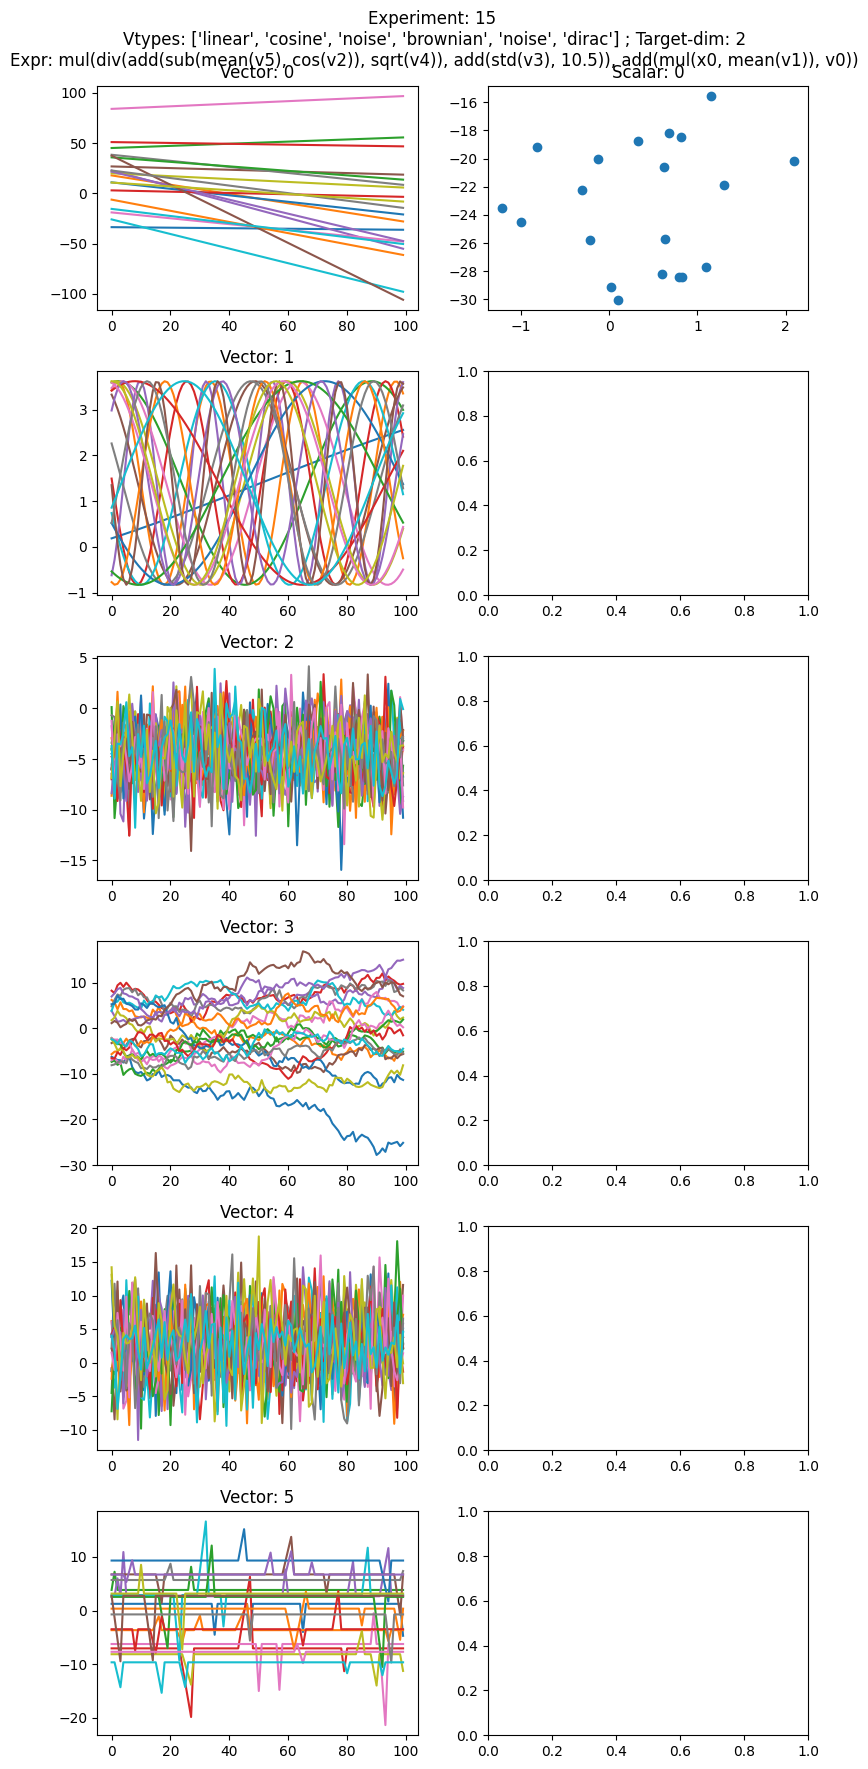

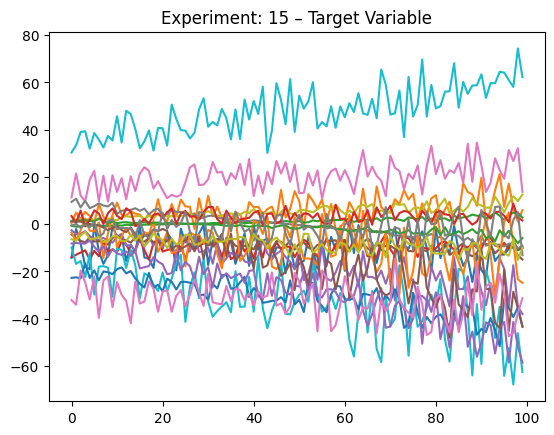

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Test
def test_exp(k: int):

    assert k in EXPERIMENTS, 'k not in experiments'

    X3d, X2d, y = wrap_experiment(exp_n=k, n_obs=20, v_len=100, seed=42, clip_series=False)

    print("Shapes  X3d:", X3d.shape, " X2d:", X2d.shape, " y:", y.shape)
    print("Ground‑truth (PolySym):", EXPERIMENTS[k]["expr_polysym"])

    nvec = X3d.shape[1]
    nsca = X2d.shape[1]
    nrow = max(nvec, nsca)
    fig, axes = plt.subplots(nrow, 2, figsize=(8, nrow*3))

    axes = axes.reshape(nrow, 2)

    for v in range(nvec):
        ax = axes[v, 0]
        vec = X3d[:, v, :]
        ax.plot(vec.T)
        ax.set_title(f'Vector: {v}')

    for s in range(nsca):
        ax = axes[s, 1]
        scals = X2d[:, s]
        ax.scatter(np.random.normal(size=X2d.shape[0]), scals)
        ax.set_title(f'Scalar: {s}')

    exd = EXPERIMENTS[k]

    fig.suptitle(f'Experiment: {k} \nVtypes: {exd["v_types"]} ; Target-dim: {exd["target_dim"]}\nExpr: {exd["expr_polysym"]}')
    fig.tight_layout()
    plt.show()

    fig, ax = plt.subplots()
    if y.dim() == 1:
        ax.scatter(np.random.normal(size=X2d.shape[0]), y)
    else:
        ax.plot(y.T)

    # Test y standard dev
    # check if enough variability to prevent naive model to express high perf
    # Min/max scaling
    flat_y = y.T.flatten()
    mask = flat_y.isnan()
    flat_y = flat_y[~mask]
    mean_y = torch.mean(flat_y)
    minmax = flat_y.max() - flat_y.min()
    norm_y = (flat_y - mean_y) / minmax
    sd_norm_y = torch.std(norm_y)

    # In pure random non-normal array between 0 and 1 std is .3
    # Betwen -1 and 1 std is .6
    # So if norm y std is less than 10th of this there's a problem
    if sd_norm_y < .06:
        print(f'Warning with experiment {k} – target var normalized std is very low\n\n')
    if sd_norm_y.isnan():
        print(f'Warning with experiment {k} – target var normalized std is nan\n\n')


    ax.set_title(f'Experiment: {k} – Target Variable')
    plt.show()

test_exp(15)


In [6]:
from polysym.torch_operators_2 import Operators
from polysym.model import PolySymModel
from polysym.evaluation import r2

for k, exd in EXPERIMENTS.items():

    X3d, X2d, y = wrap_experiment(exp_n=k, n_obs=20, v_len=100, seed=42, clip_series=True)

    model = PolySymModel(X3d=X3d,
                         X2d=X2d,
                         y=y,
                         operators=None,
                         max_iter=300,
                         min_complexity=1,
                         max_complexity=4,
                         pop_size=1000,
                         fitness_fn=r2,
                         fitness_obj=1,
                         verbose=1,
                         workers=-1,
                         seed=42)

    expr = exd['expr_polysym']

    print(f"Experiment {k}:\neval expr r2={model.eval_expr(expr):.2f};"
          f" tree depth= {model.get_expr(expr).height}\nexpr: {expr}\n\n")

Experiment 1:
eval expr r2=1.00; tree depth= 3
expr: add(sqrt(abs(v0)), x0)


Experiment 2:
eval expr r2=1.00; tree depth= 5
expr: add(mul(x0, mean(sqrt(mul(v0,v1)))), max(v1))


Experiment 3:
eval expr r2=1.00; tree depth= 4
expr: add(mul(div(sum(v0), mean(v1)), mean(v2)), x0)


Experiment 4:
eval expr r2=1.00; tree depth= 5
expr: add(add(div(mul(v0, 2.3), neg(v1)), div(x0, sub(mean(v2), -6.7))), mul(x1, center(v3)))


Experiment 5:
eval expr r2=1.00; tree depth= 3
expr: add(mul(v0, x0), square(abs(x1)))


Experiment 6:
eval expr r2=1.00; tree depth= 5
expr: add(sub(div(std(v0), add(mean(v1), 30.4)), sub(x2, x0)), mul(x1, mean(v1)))


Experiment 7:
eval expr r2=1.00; tree depth= 5
expr: add(sub(v4, sqrt(abs(sub(v2, v0)))), add(mul(x0, center(v1)), v3))


Experiment 8:
eval expr r2=1.00; tree depth= 4
expr: div(sub(sum(v2), add(abs(v1), min(v0))), x0)


Experiment 9:
eval expr r2=1.00; tree depth= 4
expr: add(add(mean(mul(v0, v1)), x1), x0)


Experiment 10:
eval expr r2=1.00; tree dept

In [63]:
k=3
cfd = EXPERIMENTS[k]
X3d, X2d, y = wrap_experiment(exp_n=k, n_obs=100, v_len=50, seed=42, clip_series=True)
print(cfd['expr_polysym'])

ops = Operators(['neg', 'abs', 'sin', 'cos', 'sqrt', 'square', 'center',
                 'mean', 'median', 'sum', 'std', 'min', 'max',
                 'add', 'sub', 'mul', 'div'])

# ops = Operators(['add', 'mul', 'div', 'sum', 'mean'])

model = PolySymModel(X3d=X3d,
                     X2d=X2d,
                     y=y,
                     operators=ops,
                     max_iter=100,
                     min_complexity=1,
                     max_complexity=4,
                     pop_size=1500,
                     fitness_fn=r2,
                     fitness_obj=1,
                     add_constants=False,
                     optimize_ephemerals=False,
                     verbose=1,
                     workers=-1,
                     seed=42
                     )

model.fit()

# TODO: Compare models with train/test and out of distribution: PolySym should always outperform out of pop measures

add(mul(div(sum(v0), mean(v1)), mean(v2)), x0)


2025-05-16 08:32:21,058 - INFO - Running iteration 0/100; best fit=-inf
2025-05-16 08:32:26,045 - INFO - Running iteration 10/100; best fit=0.62
2025-05-16 08:32:30,442 - INFO - Running iteration 20/100; best fit=0.63
2025-05-16 08:32:32,965 - INFO - Running iteration 30/100; best fit=0.63
2025-05-16 08:32:35,187 - INFO - Running iteration 40/100; best fit=0.63
2025-05-16 08:32:37,619 - INFO - Running iteration 50/100; best fit=0.63
2025-05-16 08:32:41,429 - INFO - Running iteration 60/100; best fit=0.63
2025-05-16 08:32:45,282 - INFO - Running iteration 70/100; best fit=0.63
2025-05-16 08:32:49,294 - INFO - Running iteration 80/100; best fit=0.63
2025-05-16 08:32:53,261 - INFO - Running iteration 90/100; best fit=0.63
2025-05-16 08:32:57,746 - INFO - Finished iterating, wrapping up fitting...
2025-05-16 08:32:57,747 - INFO - Overall best depth=3 fitness=0.63 ; expr=sub(sub(mean(v0), div(x0, x0)), abs(neg(x0)))


In [58]:
model.fitted = True
model.summary(pretty_print=False)

Best depth=4

Depth=1 fitness=0.13 expr: min(v0)

Depth=2 fitness=0.62 expr: mean(add(x0, v0))

Depth=3 fitness=0.63 expr: sub(median(add(v0, v2)), add(neg(x0), sin(x0)))

Depth=4 fitness=0.63 expr: min(sub(mean(add(v0, x0)), sin(abs(v1))))



375

In [30]:
test_tree = model.get_expr(str(model.hof[0]))

test_tree == model.hof[0]

False

In [19]:
expr = cfd['expr_polysym']
print(expr)
print(model.eval_expr(expr))

add(mul(div(sum(v0), mean(v1)), mean(v2)), x0)
1.0


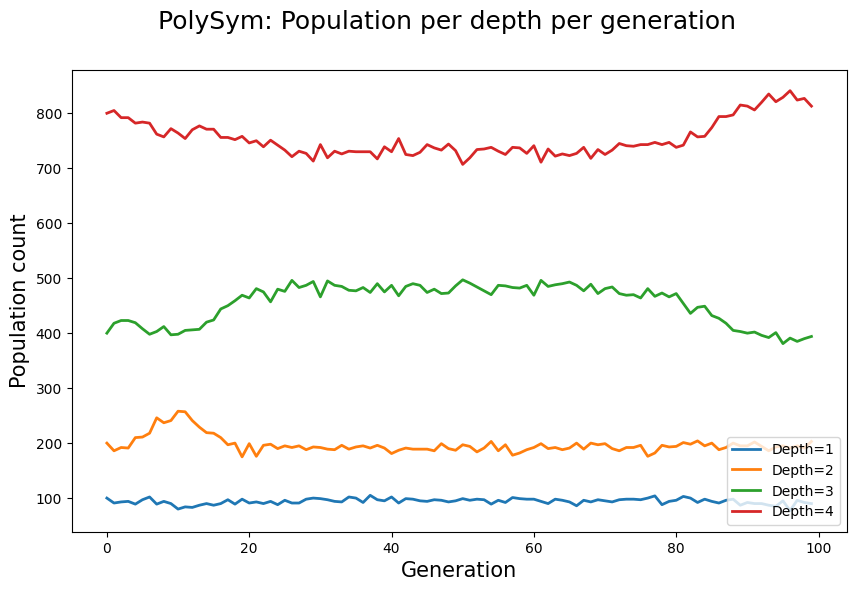

In [55]:
model.plot_depth_per_gen()

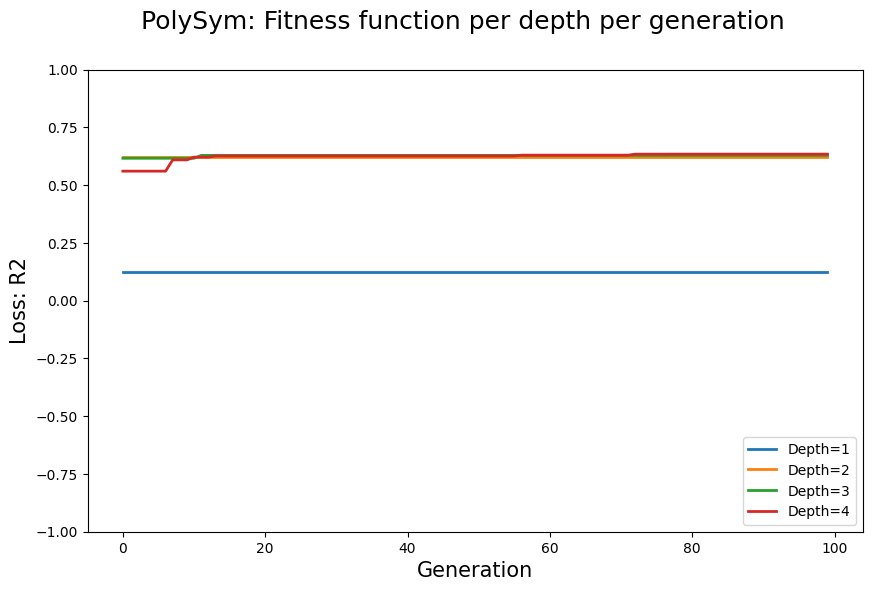

In [56]:
model.plot_differential_loss()

In [34]:
model.eval_expr(cfg['expr_polysym'])

1.0

In [35]:
tree = model.get_expr(cfg['expr_polysym'])

In [38]:
tree.height

3